# 9th International Fire Ecology and Management Congress: Google Earth Engine: Data and Information from the Cloud to your House

Isaac Arroyo-Velázquez , Enrique Camacho-Pérez

Universidad Autónoma de Yucatán  
Tecnológico Nacional de México Campus Progreso 

<img src="../figures/universidades_logos.jpg" alt="Logos de Universidades" style="width:700px"/>

## Methods

The following lines of code are an adaptation (or translation) from the GEE Code Editor (JavaScript) to Python.

### Import necessary libraries 

In [1]:
# ====== DATA SCIENCE/ANALYSIS LIBRARIES ======
# Data manipulation and scientific computing
import numpy as np
import pandas as pd
# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rc('font', family='serif')
import seaborn as sns
import folium # Interactive maps

# ====== GOOGLE EARTH ENGINE TOOLS ======
import ee # official GEE Python API             
import eemont # Extension: Data pre-processing
import geemap # Extension: Interactive maps and data transformation

### Initialize GEE API

In [2]:
ee.Initialize()

### Load the satellite images

The data comes from Google Earth Engine Data Catalog:

* [Land Surface Temperature](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1)
* [Precipitation or Rainfall](https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_PENTAD?hl=en)
* [Forest Change](https://developers.google.com/earth-engine/datasets/catalog/UMD_hansen_global_forest_change_2020_v1_8?hl=en)

In [3]:
# Temperature 
ImgColl_Temperature = ee.ImageCollection("MODIS/006/MOD11A1")
# Precipitation
ImgColl_Precipitation = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD")
# Forest Cover Change
Img_Forest = ee.Image("UMD/hansen/global_forest_change_2020_v1_8")

### Filter by date (`.filterDate()`)

This filter is only applied to Image Collections

In [4]:
# 5 Years, from Jan 2016 to Dec 2020
Date_Start = '2016-01-01'
Date_End = '2020-12-31'

# Apply filters to data
ImgColl_Temperature = ImgColl_Temperature.filterDate(Date_Start, Date_End)
ImgColl_Precipitation = ImgColl_Precipitation.filterDate(Date_Start, Date_End)

### Select bands

To get the information of each image band, follow the links embedded in the "Get the data" section. 

Once doing it, there is a section named "Bands" with all the Image/Image Collection's band information.

![Data information in Google Earth Engine](../figures/band_info_gee.jpg)

In [5]:
ImgColl_Temperature = ImgColl_Temperature.select(['LST_Day_1km'])
ImgColl_Precipitation = ImgColl_Precipitation.select(['precipitation'])
Img_LossForest_Year = Img_Forest.select(['lossyear'])

### Unit conversion (Temperature)

The temperature is scaled and in Kelvin. To convert each image's temperature information use the `map` function (instead of going through each image and applying the same operation)

In [6]:
def func_kelvin_to_celsius(image):
    scale_image = image.multiply(0.02)
    to_celsius = scale_image.subtract(273.15)
    final = to_celsius.copyProperties(image, ['system:time_start'])
    return final

In [7]:
ImgColl_Temperature = ImgColl_Temperature.map(func_kelvin_to_celsius)

### Extract the data

A Region of Interest (ROI) must be declared to **reduce** the information from the satellite images.

In this case, will be a rectangle inside the state of Yucatan, Mexico.

#### Region of Interest (ROI)

In [8]:
ROI = ee.Geometry.Rectangle([(-89.84, 21.18),(-88.09, 20.47)])

#### Time series data

In [9]:
# Using the eemont library
FeatureColl_TimeSeries_meanTemperature = ImgColl_Temperature\
                                         .getTimeSeriesByRegion(reducer=[ee.Reducer.mean()], 
                                                                geometry = ROI,
                                                                bands = ['LST_Day_1km'],
                                                                dateColumn = 'Date',
                                                                naValue = -9999, # value assigned to "missing values/data"
                                                                scale = 1000
                                                                )

FeatureColl_TimeSeries_meanPrecipitation = ImgColl_Precipitation\
                                           .getTimeSeriesByRegion(reducer=[ee.Reducer.mean()], 
                                                                  geometry = ROI,
                                                                  bands = ['precipitation'],
                                                                  dateColumn = 'Date',
                                                                  naValue = -9999, 
                                                                  scale = 1000
                                                                  )

In [10]:
# Using geemap library convert into a pandas data frame
df_ts_meanTemp = geemap.ee_to_pandas(FeatureColl_TimeSeries_meanTemperature)
df_ts_meanPrec = geemap.ee_to_pandas(FeatureColl_TimeSeries_meanPrecipitation)

In [11]:
# View of the data frame
df_ts_meanTemp.head(10)

,Date,LST_Day_1km,reducer
0,2016-01-01T00:00:00,26.625767,mean
1,2016-01-02T00:00:00,26.777246,mean
2,2016-01-03T00:00:00,28.353901,mean
3,2016-01-04T00:00:00,21.717240,mean
4,2016-01-05T00:00:00,-9999.000000,mean
5,2016-01-06T00:00:00,25.216930,mean
6,2016-01-07T00:00:00,25.902681,mean
7,2016-01-08T00:00:00,26.139828,mean
8,2016-01-09T00:00:00,27.093296,mean
9,2016-01-10T00:00:00,23.495778,mean


In [12]:
# Clean and process data frames
def clean_df(dataframe, columns_rename=None):
    """
    * `dataframe` _(pandas.DataFrame)_ : time series data from GEE
    * `columns_rename` _(dict)_ : columns to be ranamed (format: {'Old Name':'New Name'})
    """
    dataframe_final = dataframe.rename(columns=columns_rename)
    dataframe_final['Date'] = pd.to_datetime(dataframe_final['Date'])
    dataframe_final = dataframe_final.set_index('Date', inplace=False)
    dataframe_final = dataframe_final.drop(columns=['reducer'], inplace=False)
    try:
        # Check for "missing values" aka values = -9999
        dataframe_final = dataframe_final[dataframe_final.iloc[:,0]!=-9999.0]
    except KeyError:
        pass
    dataframe_final['Year'] = dataframe_final.index.year
    dataframe_final['Month'] = dataframe_final.index.month
    dataframe_final['WeekOfYear'] = dataframe_final.index.isocalendar().week
    return dataframe_final


In [13]:
df_ts_meanTemp = clean_df(dataframe= df_ts_meanTemp, columns_rename={'LST_Day_1km': 'Mean Temperature (Celsius)'})
df_ts_meanPrec = clean_df(dataframe= df_ts_meanPrec, columns_rename={'precipitation': 'Mean Precipitation (mm/5day)'})

### Data visualization

#### Time series: Matplotlib

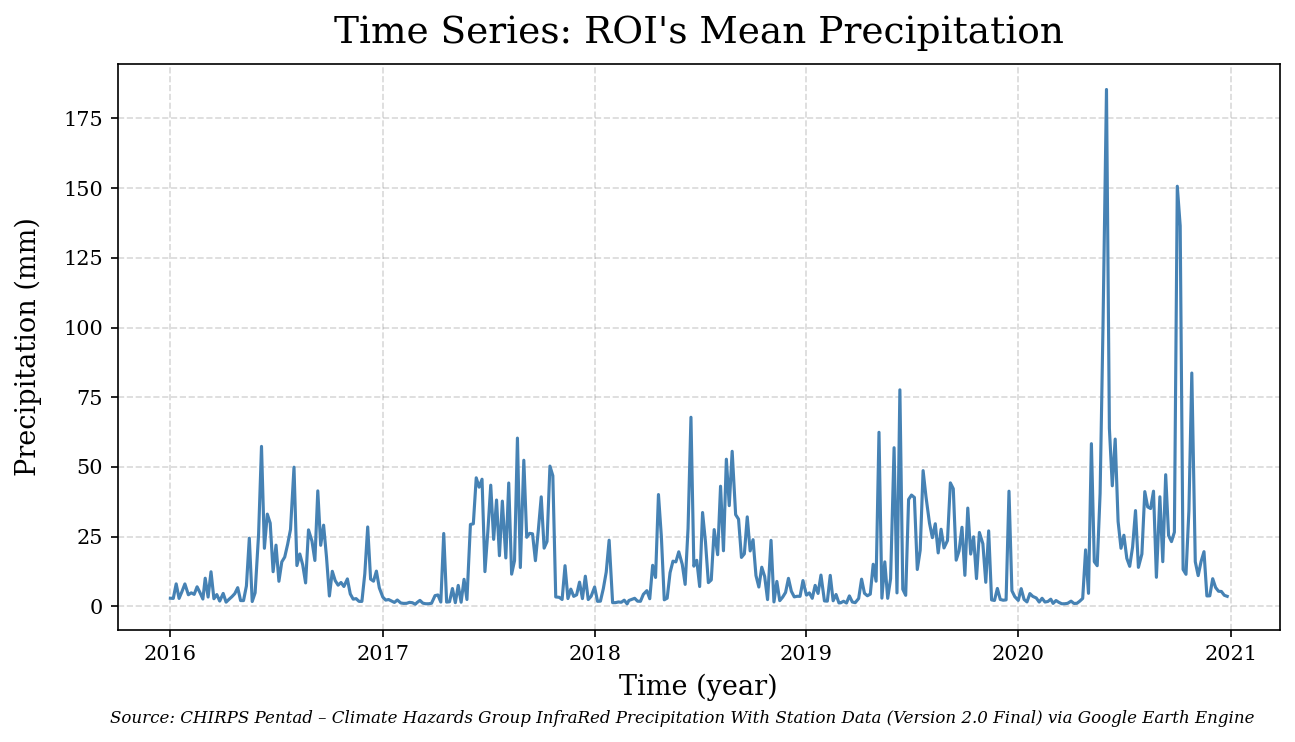

In [14]:
fig, ax = plt.subplots(figsize=(10,5),dpi=150)

ax.plot(df_ts_meanPrec.index, df_ts_meanPrec['Mean Precipitation (mm/5day)'], color='steelblue')
ax.grid(color='gray',alpha=0.3, ls='dashed')


ax.set_xlabel('Time (year)', size=13, labelpad=5)
ax.set_ylabel('Precipitation (mm)', size=13, labelpad=10)
ax.set_title("Time Series: ROI's Mean Precipitation", size=18, pad=10)
ax.tick_params(labelsize=10)

caption = 'Source: CHIRPS Pentad – Climate Hazards Group InfraRed Precipitation With Station Data (Version 2.0 Final) via Google Earth Engine'
fig.text(0.12,0.001, caption,fontdict={'size':8, 'style':'italic'})

plt.show()

#### Heat Map: Seaborn

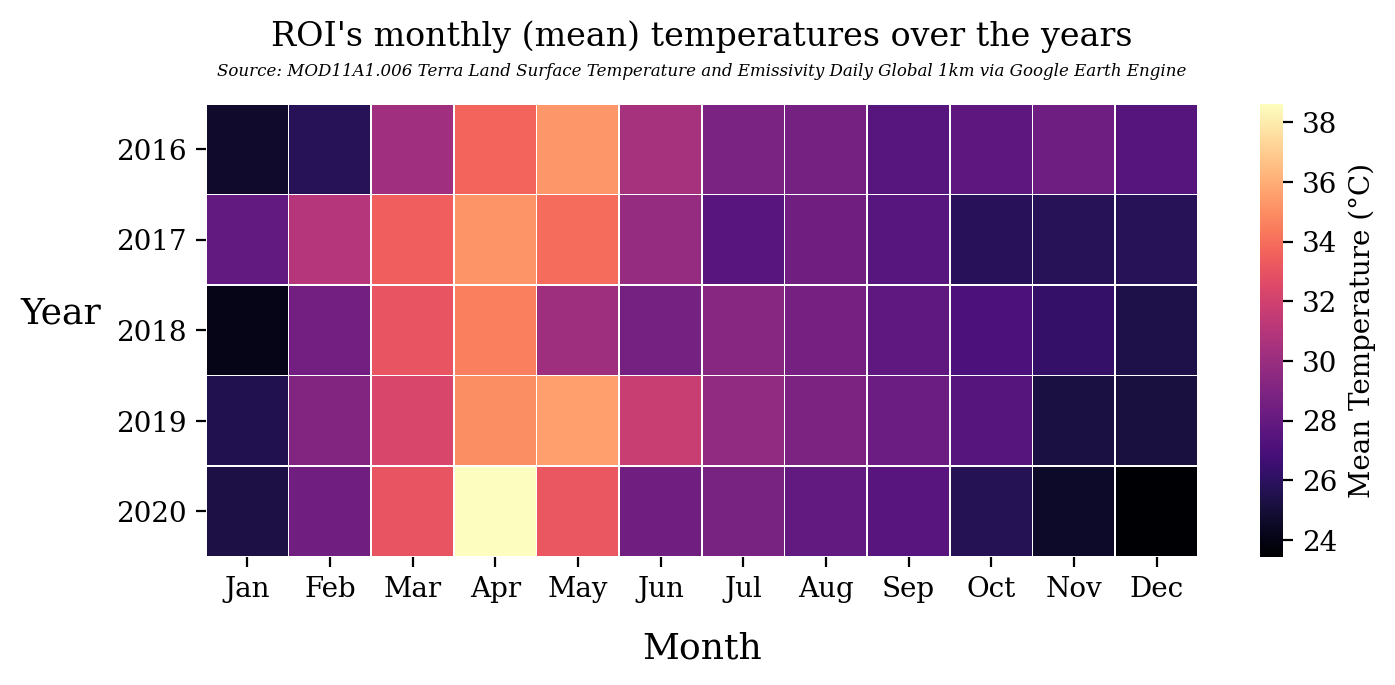

In [15]:
# Resample by month (to eliminate duplicates)
df_ts_meanTemp_month = df_ts_meanTemp.resample('M').mean()
# Create pivot table
df_ts_meanTemp_pivot = df_ts_meanTemp_month.pivot(index="Year", columns="Month", values="Mean Temperature (Celsius)")
List_Months = ['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec' ]

# Create heatmap (calendar)
fig, ax = plt.subplots(figsize = (8,3), dpi=200)

heatmap = sns.heatmap(data=df_ts_meanTemp_pivot,
                      xticklabels = List_Months,
                      lw = 0.2,
                      ax=ax,
                      cmap= 'magma',
                      cbar_kws = {'label': 'Mean Temperature (°C)'},
                     )



ax.set_xlabel('Month', size = 13, labelpad=10)
ax.set_ylabel('Year', size = 13, labelpad=20, rotation='horizontal')
ax.tick_params(axis='y', rotation=0)
fig.suptitle("ROI's monthly (mean) temperatures over the years",x=0.435,y=1.02)

caption = "Source: MOD11A1.006 Terra Land Surface Temperature and Emissivity Daily Global 1km via Google Earth Engine"
ax.set_title(caption, size=6, pad= 10, fontdict={'style':'italic'} )
plt.show()


#### Interactive map: Folium

Add the followign method to the `folium.Map` objetc to create interactive maps with Folium


More information: [_Python Installation_](https://developers.google.com/earth-engine/guides/python_install)


In [16]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

To display the Region of Interest information in a map, the user can use the `.clip()` method. This method is only applied to an `ee.Image` object.

To convert an Image Collection into an Image, use a reducer, like the mean.

In [17]:
# Reduce image collections into images
Img_Temperature = ImgColl_Temperature.mean()\
                  .clip(ROI) # display only the region of interest
Img_Precipitation = ImgColl_Precipitation.mean().clip(ROI)

# Show forest loss over the years
Img_LossForest_Year = Img_LossForest_Year.clip(ROI)

In [18]:
# Set visualization parameters
VisParams_Temperature = {
  'min': 27,
  'max': 34,
  'palette':['blue', 'limegreen', 'yellow', 'darkorange', 'red']
}

VisParams_Precipitation = {
  'min': 15,
  'max': 30,
  'palette': ['00B4D8','0096C7','0077B6','023E8A','03045E']
}
VisParams_LossForest_Year = {
  'min': 0, 
  'max': 20,
  'palette': ['001219', '005f73', '0a9396',
  '94d2bd', 'e9d8a6','ee9b00', 'ca6702',
  'bb3e03', 'ae2012', '9b2226']
}

In [19]:
mapa_folium = folium.Map(location=[20.84,-89.01],zoom_start=9)

mapa_folium.add_ee_layer(Img_Temperature, VisParams_Temperature, "Mean Temperature (2016-2020)")
mapa_folium.add_ee_layer(Img_Precipitation, VisParams_Precipitation, "Mean Precipitation (2016-2020)")
mapa_folium.add_ee_layer(Img_LossForest_Year, VisParams_LossForest_Year, "Forest Loss (2000-2020)")

# Add a layer control panel to the map.
mapa_folium.add_child(folium.LayerControl())

# Save map
mapa_folium.save("../maps/folium_map_example.html")

display(mapa_folium)

A closer look at the Forest Loss information

![Forest loss – Map](../figures/forest_loss_years_yuc.png)

#### Interactive map: geemap

There's another alternative: use `geemap`

Official documentation: [Welcome to geemap](https://geemap.org)

In [20]:
geemap_map = geemap.Map(center=(20.84,-89.01), zoom=9)

geemap_map.addLayer(Img_Temperature, VisParams_Temperature, "Mean Temperature (2016-2020)")
geemap_map.addLayer(Img_Precipitation, VisParams_Precipitation, "Mean Precipitation (2016-2020)")
geemap_map.addLayer(Img_LossForest_Year, VisParams_LossForest_Year, "Forest Loss (2001-2020)")

geemap_map

Map(center=[20.84, -89.01], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childr…